In [ ]:
%pip install torch
%pip install torchvision

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [2]:
digits = [1, 2, 3, 4, 5, 7]
rotations = [0, 90, 180, 270]

class RotatedMNIST(Dataset):
    def __init__(self, root, train=True, digits=digits, rotations=rotations):
        #transform to tensor
        self.original_dataset = datasets.MNIST(root=root, train=train, transform=transforms.ToTensor(), download=True)
        self.digits = digits
        self.rotations = rotations
        self.digit_to_idx = {d: i for i, d in enumerate(digits)}

        self.data = []
        self.digit_labels = []
        self.rotation_labels = []

        for img, label in self.original_dataset:
            if label in digits:
                for rotation in rotations:
                    rotated_img = transforms.functional.rotate(img, rotation)
                    self.data.append(rotated_img)
                    self.digit_labels.append(self.digit_to_idx[label])
                    self.rotation_labels.append(rotation // 90)  # 0,1,2,3

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], (self.digit_labels[idx], self.rotation_labels[idx])

In [3]:
class MultiOutputNN(nn.Module):
    def __init__(self):
        super(MultiOutputNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)

        # After conv+pool twice, input 28x28 -> 7x7 feature maps with 16 channels
        # Flatten size = 16*7*7 = 784

        # Two separate FC layers
        self.fc_digit = nn.Linear(16*7*7, len(digits))
        self.fc_rotation = nn.Linear(16*7*7, len(rotations))

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = x.reshape(x.shape[0], -1)  # flatten

        digit_out = self.fc_digit(x)
        rotation_out = self.fc_rotation(x)
        return digit_out, rotation_out

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 497kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.58MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.31MB/s]


Full Train Dataset Size: 145436

Train Set Distribution:
Total instances: 116348

Digits:
  1 (label 0): 21572 instances (18.5%)
  2 (label 1): 19064 instances (16.4%)
  3 (label 2): 19620 instances (16.9%)
  4 (label 3): 18696 instances (16.1%)
  5 (label 4): 17348 instances (14.9%)
  7 (label 5): 20048 instances (17.2%)

Rotations:
  0° (label 0): 29087 instances (25.0%)
  90° (label 1): 29087 instances (25.0%)
  180° (label 2): 29087 instances (25.0%)
  270° (label 3): 29087 instances (25.0%)


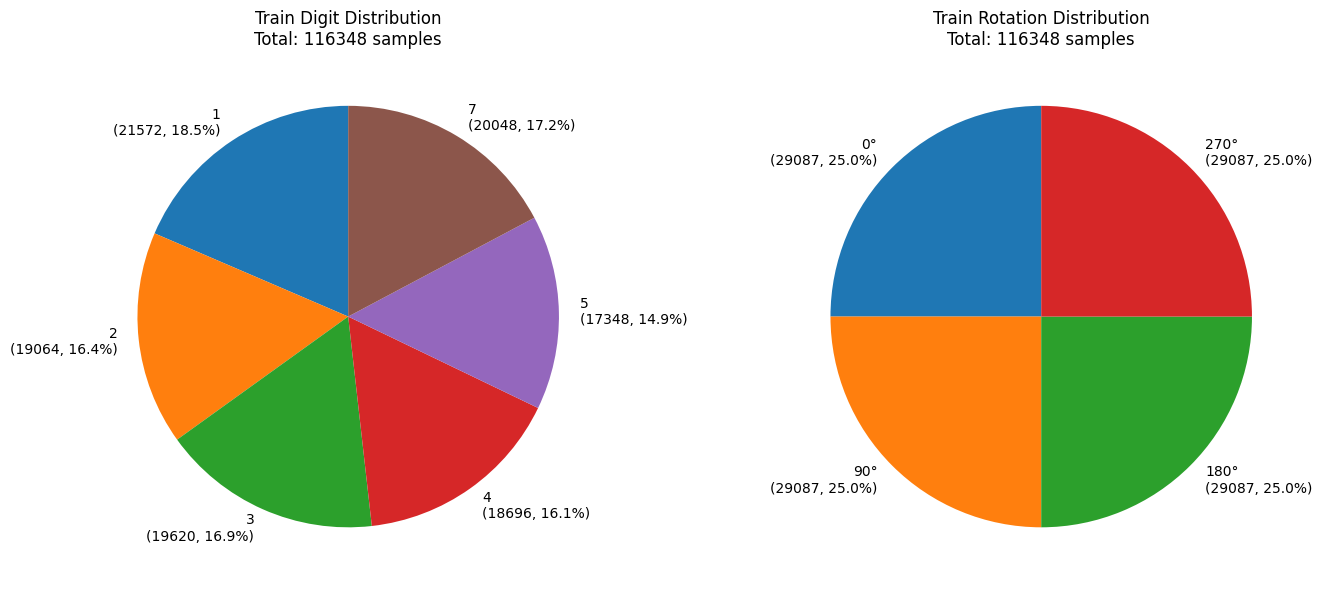


Test Set Distribution:
Total instances: 29088

Digits:
  1 (label 0): 5396 instances (18.6%)
  2 (label 1): 4768 instances (16.4%)
  3 (label 2): 4904 instances (16.9%)
  4 (label 3): 4672 instances (16.1%)
  5 (label 4): 4336 instances (14.9%)
  7 (label 5): 5012 instances (17.2%)

Rotations:
  0° (label 0): 7272 instances (25.0%)
  90° (label 1): 7272 instances (25.0%)
  180° (label 2): 7272 instances (25.0%)
  270° (label 3): 7272 instances (25.0%)


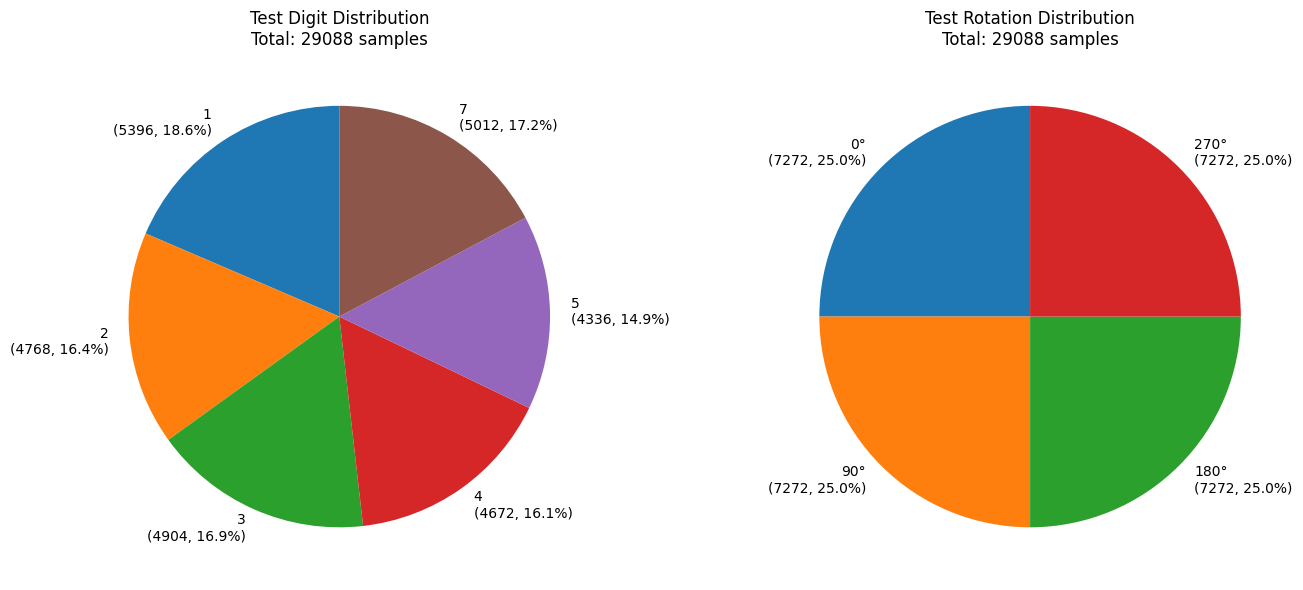

In [4]:
#full train data
full_train_dataset = RotatedMNIST(root='./data', train=True)
print(f"Full Train Dataset Size: {len(full_train_dataset)}")

#combined labels: digit * 10 + rotation
combined_labels = np.array(full_train_dataset.digit_labels) * 10 + np.array(full_train_dataset.rotation_labels)

#80% train, 20% test
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
#the split method returns indices for train and test sets according to the stratified labels
train_idx, test_idx = next(sss.split(np.zeros(len(combined_labels)), combined_labels))

train_dataset = Subset(full_train_dataset, train_idx)
test_dataset = Subset(full_train_dataset, test_idx)

def analyze_distribution(dataset, name):
    digits_arr = []
    rotations_arr = []
    for _, (d, r) in dataset:
        digits_arr.append(d)
        rotations_arr.append(r)

    digits_arr = np.array(digits_arr)
    rotations_arr = np.array(rotations_arr)

    # Digit analysis
    unique_digits, digit_counts = np.unique(digits_arr, return_counts=True)
    digit_percentages = 100 * digit_counts / len(dataset)

    # Rot percentage analysis
    unique_rotations, rotation_counts = np.unique(rotations_arr, return_counts=True)
    rotation_percentages = 100 * rotation_counts / len(dataset)

    print(f"\n{name} Set Distribution:")
    print(f"Total instances: {len(dataset)}")
    print("\nDigits:")
    for d, cnt, pct in zip(unique_digits, digit_counts, digit_percentages):
        print(f"  {digits[d]} (label {d}): {cnt} instances ({pct:.1f}%)")

    print("\nRotations:")
    for r, cnt, pct in zip(unique_rotations, rotation_counts, rotation_percentages):
        print(f"  {rotations[r]}° (label {r}): {cnt} instances ({pct:.1f}%)")

    # Plot pies
    plt.figure(figsize=(14, 6))

    # Digit pie
    plt.subplot(1, 2, 1)
    plt.pie(digit_counts, labels=[f'{digits[d]}\n({cnt}, {pct:.1f}%)'
                                for d, cnt, pct in zip(unique_digits, digit_counts, digit_percentages)],
            autopct='', startangle=90)
    plt.title(f'{name} Digit Distribution\nTotal: {len(dataset)} samples')

    # Rotation pie
    plt.subplot(1, 2, 2)
    plt.pie(rotation_counts, labels=[f'{rotations[r]}°\n({cnt}, {pct:.1f}%)'
                                   for r, cnt, pct in zip(unique_rotations, rotation_counts, rotation_percentages)],
            autopct='', startangle=90)
    plt.title(f'{name} Rotation Distribution\nTotal: {len(dataset)} samples')

    plt.tight_layout()
    plt.show()

analyze_distribution(train_dataset, 'Train')
analyze_distribution(test_dataset, 'Test')

In [5]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#model, optimizer, and loss functions
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiOutputNN().to(device)

criterion_digit = nn.CrossEntropyLoss()
criterion_rotation = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    for data, targets in train_loader:
        data = data.to(device)
        digit_targets = targets[0].to(device)
        rotation_targets = targets[1].to(device)

        digit_scores, rotation_scores = model(data)
        loss_digit = criterion_digit(digit_scores, digit_targets)
        loss_rot = criterion_rotation(rotation_scores, rotation_targets)
        loss = loss_digit + loss_rot

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs} - Digit Loss: {loss_digit.item():.4f}, Rotation Loss: {loss_rot.item():.4f}, Total Loss: {loss.item():.4f}')


Epoch 1/20 - Digit Loss: 0.2037, Rotation Loss: 0.0110, Total Loss: 0.2147
Epoch 2/20 - Digit Loss: 0.1593, Rotation Loss: 0.0074, Total Loss: 0.1667
Epoch 3/20 - Digit Loss: 0.2922, Rotation Loss: 0.0042, Total Loss: 0.2964
Epoch 4/20 - Digit Loss: 0.2787, Rotation Loss: 0.0025, Total Loss: 0.2812
Epoch 5/20 - Digit Loss: 0.1091, Rotation Loss: 0.0030, Total Loss: 0.1121
Epoch 6/20 - Digit Loss: 0.2147, Rotation Loss: 0.0128, Total Loss: 0.2275
Epoch 7/20 - Digit Loss: 0.1356, Rotation Loss: 0.0079, Total Loss: 0.1435
Epoch 8/20 - Digit Loss: 0.2050, Rotation Loss: 0.0019, Total Loss: 0.2069
Epoch 9/20 - Digit Loss: 0.1028, Rotation Loss: 0.0038, Total Loss: 0.1066
Epoch 10/20 - Digit Loss: 0.1028, Rotation Loss: 0.0007, Total Loss: 0.1035
Epoch 11/20 - Digit Loss: 0.0429, Rotation Loss: 0.0028, Total Loss: 0.0457
Epoch 12/20 - Digit Loss: 0.3341, Rotation Loss: 0.0015, Total Loss: 0.3356
Epoch 13/20 - Digit Loss: 0.1935, Rotation Loss: 0.0067, Total Loss: 0.2002
Epoch 14/20 - Digit L

In [9]:
def evaluate(model, loader, name="Evaluation"):
    model.eval()
    digit_correct = 0
    rotation_correct = 0
    overall_correct = 0
    total = 0

    all_digit_targets = []
    all_digit_preds = []
    all_rotation_targets = []
    all_rotation_preds = []

    with torch.no_grad():
        for data, targets in loader:
            data = data.to(device)
            digit_targets = targets[0].to(device)
            rotation_targets = targets[1].to(device)

            digit_scores, rotation_scores = model(data)

            _, digit_preds = torch.max(digit_scores, 1)
            _, rotation_preds = torch.max(rotation_scores, 1)

            digit_correct += (digit_preds == digit_targets).sum().item()
            rotation_correct += (rotation_preds == rotation_targets).sum().item()

            # Calculate if BOTH digit and rotation predictions are correct for each sample
            both_correct = (digit_preds == digit_targets) & \
                           (rotation_preds == rotation_targets)
            overall_correct += both_correct.sum().item()

            total += digit_targets.size(0)

            all_digit_targets.extend(digit_targets.cpu().numpy())
            all_digit_preds.extend(digit_preds.cpu().numpy())
            all_rotation_targets.extend(rotation_targets.cpu().numpy())
            all_rotation_preds.extend(rotation_preds.cpu().numpy())

    # Calculate Accuracies
    digit_accuracy = 100 * digit_correct / total
    rotation_accuracy = 100 * rotation_correct / total
    overall_accuracy = 100 * overall_correct / total

    # Calculate F1 Scores
    # Weighted F1
    digit_f1_weighted = f1_score(all_digit_targets, all_digit_preds, average='weighted', zero_division=0)
    rotation_f1_weighted = f1_score(all_rotation_targets, all_rotation_preds, average='weighted', zero_division=0)

    # Macro F1
    digit_f1_macro = f1_score(all_digit_targets, all_digit_preds, average='macro', zero_division=0)
    rotation_f1_macro = f1_score(all_rotation_targets, all_rotation_preds, average='macro', zero_division=0)

    print(f"\n--- {name} Results ---")
    print(f'Digit Accuracy: {digit_accuracy:.2f}%')
    print(f'Digit F1 Score (weighted): {digit_f1_weighted:.4f}')
    print(f'Digit F1 Score (macro): {digit_f1_macro:.4f}')
    print(f'Rotation Accuracy: {rotation_accuracy:.2f}%')
    print(f'Rotation F1 Score (weighted): {rotation_f1_weighted:.4f}')
    print(f'Rotation F1 Score (macro): {rotation_f1_macro:.4f}')
    print(f'Overall Accuracy: {overall_accuracy:.2f}%')

print("\n--- Evaluating Model ---")
evaluate(model, train_loader, "Training Set")
evaluate(model, test_loader, "Test Set")


--- Evaluating Model ---

--- Training Set Results ---
Digit Accuracy: 97.45%
Digit F1 Score (weighted): 0.9745
Digit F1 Score (macro): 0.9742
Rotation Accuracy: 99.76%
Rotation F1 Score (weighted): 0.9976
Rotation F1 Score (macro): 0.9976
Overall Accuracy: 97.26%

--- Test Set Results ---
Digit Accuracy: 96.68%
Digit F1 Score (weighted): 0.9668
Digit F1 Score (macro): 0.9664
Rotation Accuracy: 99.52%
Rotation F1 Score (weighted): 0.9952
Rotation F1 Score (macro): 0.9952
Overall Accuracy: 96.27%


In [ ]:
print("Model is on device:", next(model.parameters()).device)

Model is on device: cpu


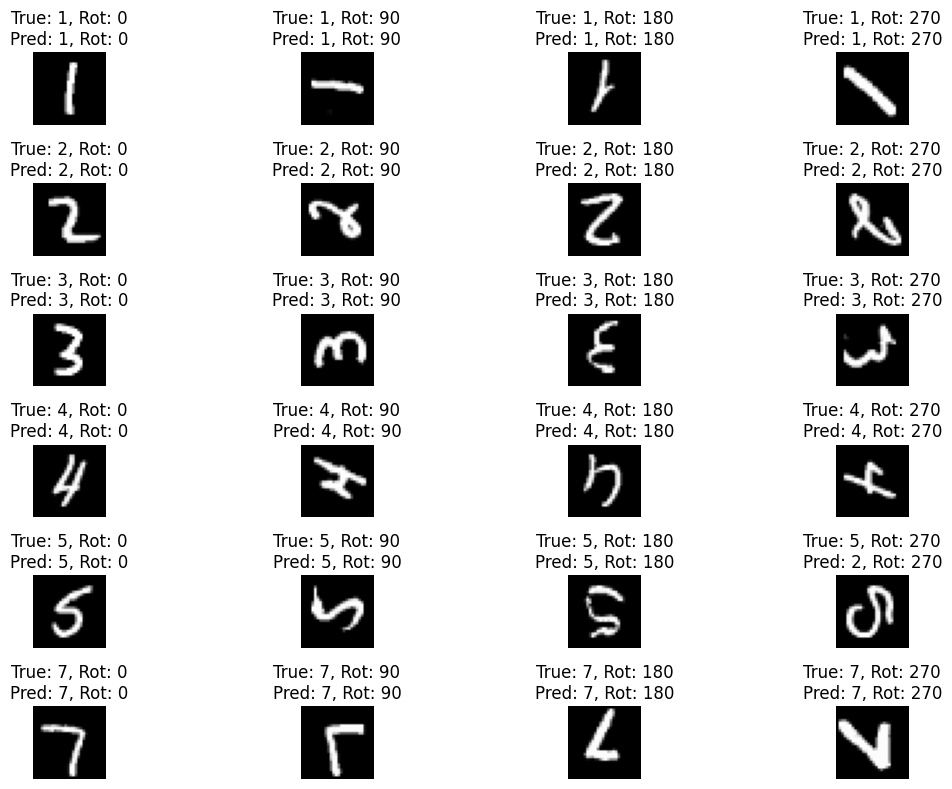

In [ ]:
def show_examples_with_preds(dataset, model, device):
    model.eval()
    fig, axs = plt.subplots(len(digits), len(rotations), figsize=(12,8))

    with torch.no_grad():
        for i, digit in enumerate(digits):
            for j, rotation in enumerate(rotations):
                for idx in range(len(dataset)):
                    img, (d, r) = dataset[idx]
                    if d == i and r == j:
                        img_tensor = img.unsqueeze(0).to(device)  # add batch dim
                        pred_digit_logits, pred_rot_logits = model(img_tensor)

                        pred_digit = pred_digit_logits.argmax(dim=1).item()
                        pred_rot = pred_rot_logits.argmax(dim=1).item()

                        img_np = img.squeeze().numpy()
                        axs[i,j].imshow(img_np, cmap='gray')
                        axs[i,j].axis('off')
                        axs[i,j].set_title(
                            f'True: {digits[d]}, Rot: {rotations[r]}\nPred: {digits[pred_digit]}, Rot: {rotations[pred_rot]}'
                        )

                        if i == 0:
                            axs[i,j].set_xlabel(f'True Rot: {rotations[j]}')
                        if j == 0:
                            axs[i,j].set_ylabel(f'True Digit: {digits[i]}')
                        break
    plt.tight_layout()
    plt.show()


show_examples_with_preds(test_dataset, model, device)
